# **Lane Lines Detection using OpenCV** 

**In this project, I utilized Python along with the OpenCV library to detect lane lines on the road. I devised a robust processing pipeline tailored to analyze a sequence of individual images, which was subsequently extended to process video streams.**

**Example of the intended output :**

---

<figure>
 <img src="OutputExample.gif" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 </figcaption>
</figure>

### Image Processing Outline:

1. **Color Selection (HSL)**:   
   - Apply HSL color selection to isolate lane lines.
   - Variations in lighting, such as shadows, glare, or changes in ambient light, can cause lane markings to appear differently in terms of brightness while maintaining their color.
    - HSL's ability to separate color from brightness allows the algorithm to remain robust against these lighting variations. 
    - It ensures that lane lines can be detected reliably across different lighting conditions, enhancing the overall robustness and performance of the lane detection system.
   - Using HSL produces the clearest lane lines of all color spaces.
   - Function: `HSL_color_selection(image)`

2. **Grayscale Conversion**:
   - The Canny edge detection algorithm measures the intensity gradients of each pixel. So, we need to convert the images into gray scale in order to detect edges.
   - Converting the color-selected image to grayscale simplifies further processing by reducing computational complexity.
   - Function: `gray_scale(color_select)`

3. **Gaussian Smoothing**:
   - Apply Gaussian smoothing to reduce noise and blur the image. 
   - Gaussian smoothing emphasizes central pixels while suppressing noise.
   - Function: `gaussian_smoothing(gray)`

4. **Edge Detection (Canny)**:
   - Detect edges in the smoothed grayscale image using the Canny edge detector.
   - Function: `canny_detector(smooth)`

5. **Region of Interest Selection**:
   - Define a region of interest to focus on relevant parts of the image (e.g., the road).
   - Focusing on relevant parts of the image reduces computational load and increases the accuracy of lane line detection.
   - The region of interest is typically a trapezoidal shape representing the area where lane lines are expected to appear in the image.
   - Function: `region_selection(edges)`

6. **Hough Transform**:
   - Apply Hough transform to detect lines in the region of interest.
   - hough_lines contains the list of lines detected in the selected region. 
   - Function: `hough_transform(region)`

7. **Averaging and extrapolating the lane lines**:
   - Detect lane lines using the hough_lines produced from Hough Transform.
   - We have multiple lines detected for each lane line. 
   - We need to average all these lines and draw a single line for each lane line. 
   - We also need to extrapolate the lane lines to cover the full lane line length.
   - Function: `lane_lines(image, hough_lines)`

8. **Drawing Lane Lines**:
   - Draw detected lane lines on a blank image.
   - The detected lane lines drawn on the blank image are combined with the original input image using cv2.addWeighted(). 
   - This function blends the two images together, producing an output image where the lane lines are overlaid on top of the original image.
   - The function returns the resulting image with the detected lane lines overlaid.
   - Function: `draw_lane_lines(image, lane_lines)`

9. **Result**:
   - Final image with detected lane lines overlaid.
   - Lane line detection is a fundamental component of many advanced driver assistance systems (ADAS) and autonomous vehicles, contributing to enhanced road safety and automation.
   - Variable: `result`

10. **Apply on video streams**:
    - frame_processor function is designed to process a single frame of a video to detect lane lines.
    - This function applies a series of image processing steps, including color selection, grayscale conversion, edge detection, Hough transform for line detection, and drawing lane lines.
    - The processed video stream, containing frames with detected lane lines overlaid, is obtained using fl_image with frame_processor applied to each frame of the input video.

## 1. Loading test images

We have 8 test images. We will write a function called `list_images()` that will show all the test images we're working on.

In [1]:
#Importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import glob
from moviepy.editor import VideoFileClip

%matplotlib inline

In [2]:
def list_images(images, cols=2, rows=5, cmap=None):
    """
    Display a list of images in a single figure with matplotlib.
    
    Parameters:
        images: List of np.arrays compatible with plt.imshow.
        cols (Default = 2): Number of columns in the figure.
        rows (Default = 5): Number of rows in the figure.
        cmap (Default = None): Used to display gray images.
    """
    # Create a figure with specified size
    plt.figure(figsize=(10, 11))
    
    # Iterate over images and plot them
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        
        # Use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape) == 2 else cmap
        
        # Display the image
        plt.imshow(image, cmap=cmap)
        
        # Remove ticks on x and y axes
        plt.xticks([])
        plt.yticks([])
    
    # Adjust layout of subplots
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    
    # Show the plot
    plt.show()


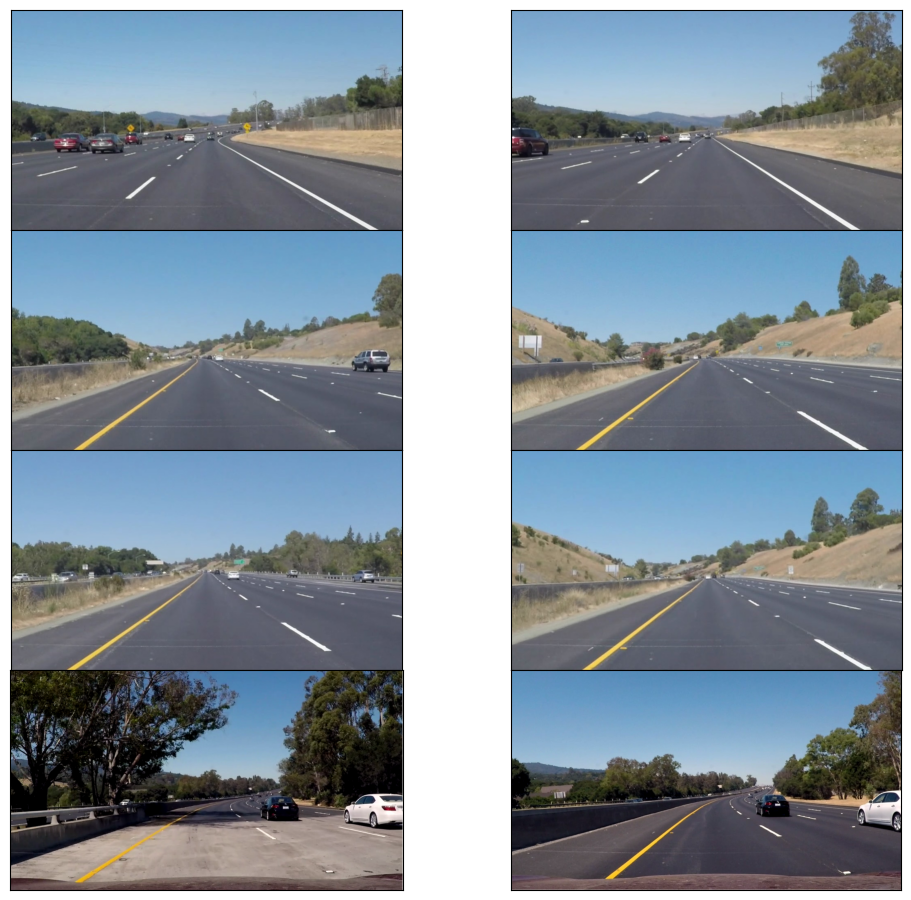

In [3]:
#Reading in the test images
test_images = [plt.imread(img) for img in glob.glob('test_images/*.jpg')]
list_images(test_images)

## 2. Color Selection

Lane lines in the test images are in white and yellow. We need to choose the most suitable color space, that clearly highlights the lane lines.

###  a) Original RGB color selection

- I will apply color selection to the `test_images` in the original RGB format. 
- We will try to retain as much of the lane lines as possible, while blacking out most of the other stuff.

In [4]:
def RGB_color_selection(image):
    """
    Apply color selection to RGB images to blackout everything except for white and yellow lane lines.
    Parameters:
        image: An np.array compatible with plt.imshow.
    """
    #White color mask
    lower_threshold = np.uint8([200, 200, 200])
    upper_threshold = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower_threshold, upper_threshold)
    
    #Yellow color mask
    lower_threshold = np.uint8([175, 175,   0])
    upper_threshold = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower_threshold, upper_threshold)
    
    #Combine white and yellow masks
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    
    return masked_image

In [5]:
# list_images(test_images)

Applying color selection to `test_images` in the RGB color space.

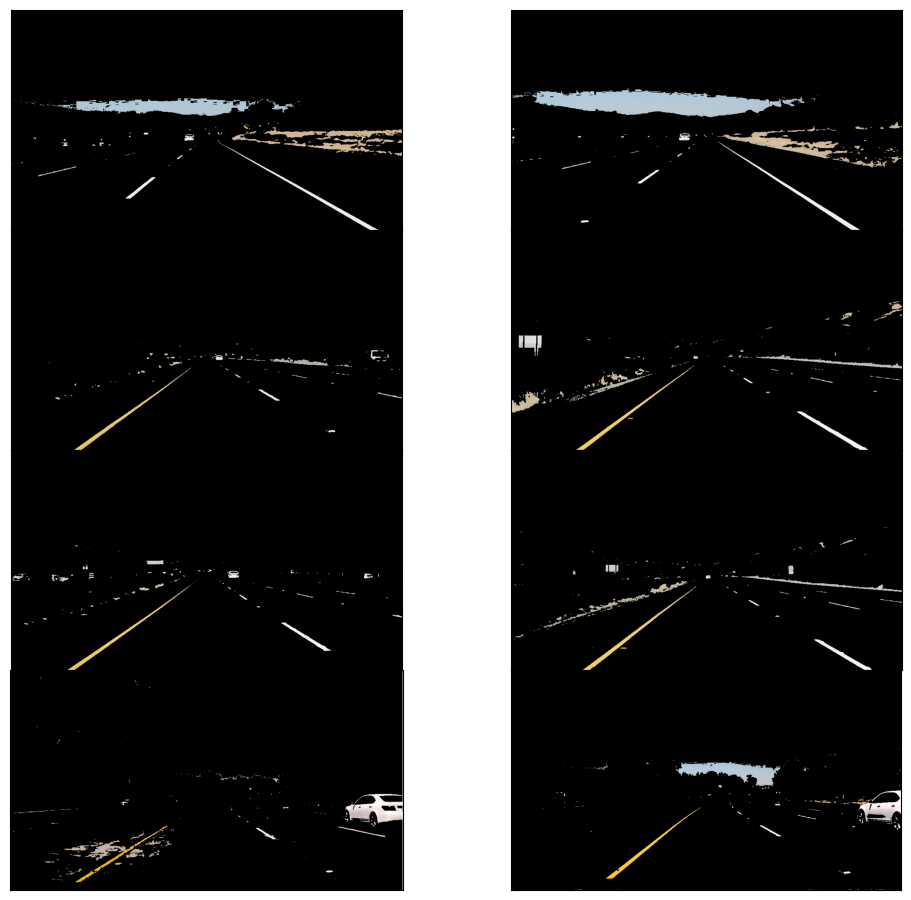

In [6]:
list_images(list(map(RGB_color_selection, test_images)))

In [7]:
# list_images(test_images)

### b) HSV color space

- The HSV color space, or Hue, Saturation, and Value, represents colors in terms of their hue (the type of color), saturation (the intensity of the color), and value (the brightness of the color). 
- Hue ranges from 0 to 360 degrees, representing different colors of the spectrum. 
- Saturation determines how vivid or muted a color appears, with 0% being grayscale and 100% being fully saturated. 
- Value controls the brightness of the color, ranging from black at 0 to white at 100.

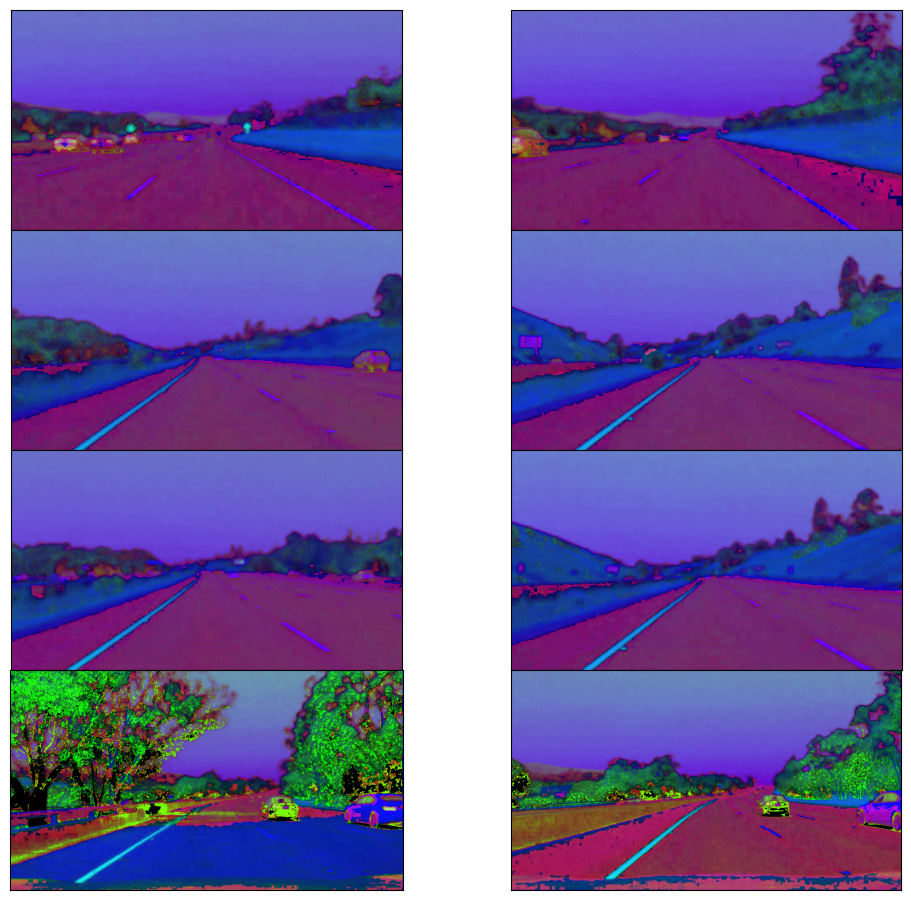

In [8]:
def convert_hsv(image):
    """
    Convert RGB images to HSV.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

list_images(list(map(convert_hsv, test_images)))

In [9]:
# list_images(test_images)

In [10]:
def HSV_color_selection(image):
    """
    Apply color selection to the HSV images to blackout everything except for white and yellow lane lines.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    #Convert the input image to HSV
    converted_image = convert_hsv(image)
    
    #White color mask
    lower_threshold = np.uint8([0, 0, 210])
    upper_threshold = np.uint8([255, 30, 255])
    white_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    #Yellow color mask
    lower_threshold = np.uint8([18, 80, 80])
    upper_threshold = np.uint8([30, 255, 255])
    yellow_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    #Combine white and yellow masks
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    
    return masked_image

Applying color selection to `test_images` in the HSV color space.

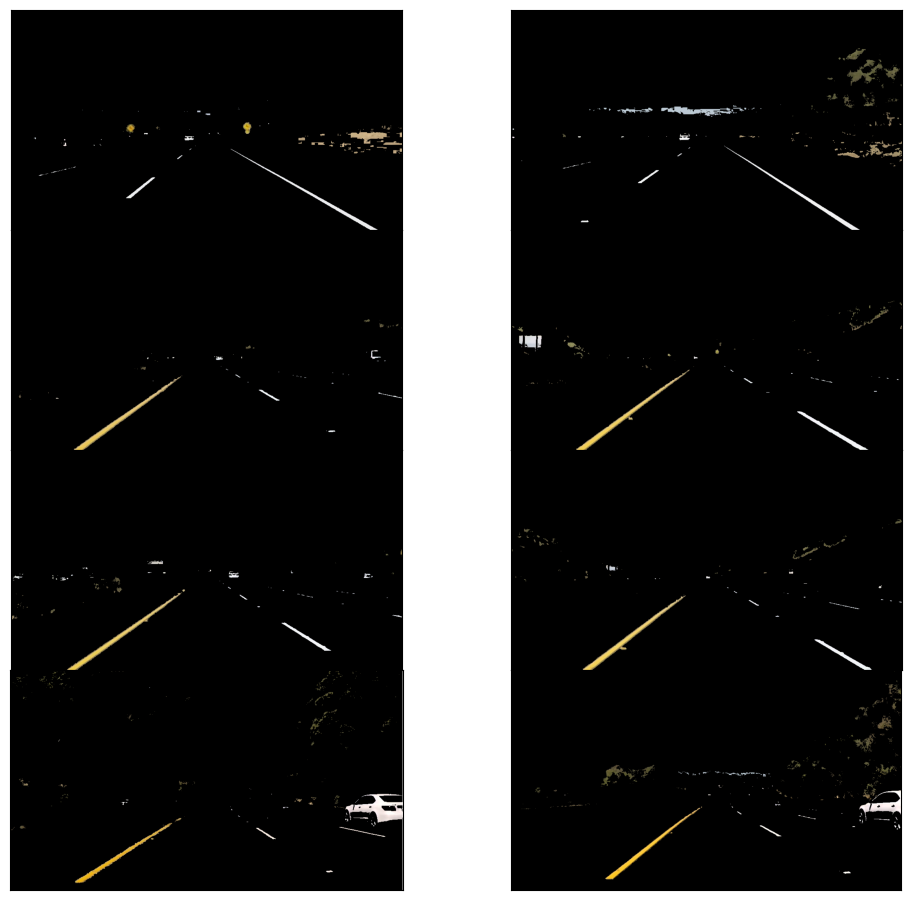

In [11]:
list_images(list(map(HSV_color_selection, test_images)))

### c) HSL color space

- The HSL (Hue, Saturation, Lightness) color space is a way to represent colors based on their hue (type of color), saturation (intensity of color), and lightness (brightness of color). 
- Hue is represented as an angle from 0 to 360 degrees, covering the spectrum of colors. 
- Saturation determines the purity of the color, with 0% being grayscale and 100% being fully saturated. 
- Lightness controls the brightness of the color, with 0% being black, 100% being white, and 50% being the original color.

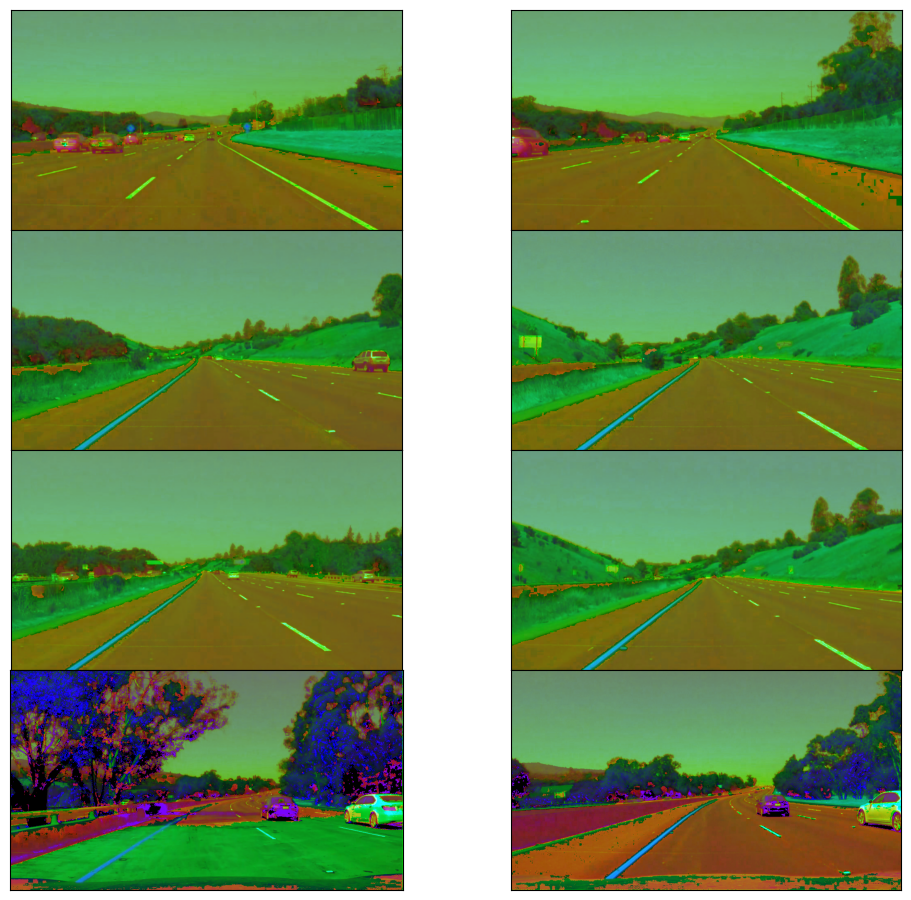

In [12]:
def convert_hsl(image):
    """
    Convert RGB images to HSL.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

list_images(list(map(convert_hsl, test_images)))

In [13]:
def HSL_color_selection(image):
    """
    Apply color selection to the HSL images to blackout everything except for white and yellow lane lines.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    #Convert the input image to HSL
    converted_image = convert_hsl(image)
    
    #White color mask
    lower_threshold = np.uint8([0, 200, 0])
    upper_threshold = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    #Yellow color mask
    lower_threshold = np.uint8([10, 0, 100])
    upper_threshold = np.uint8([40, 255, 255])
    yellow_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    #Combine white and yellow masks
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    
    return masked_image

Applying color selection to `test_images` in the HSL color space.

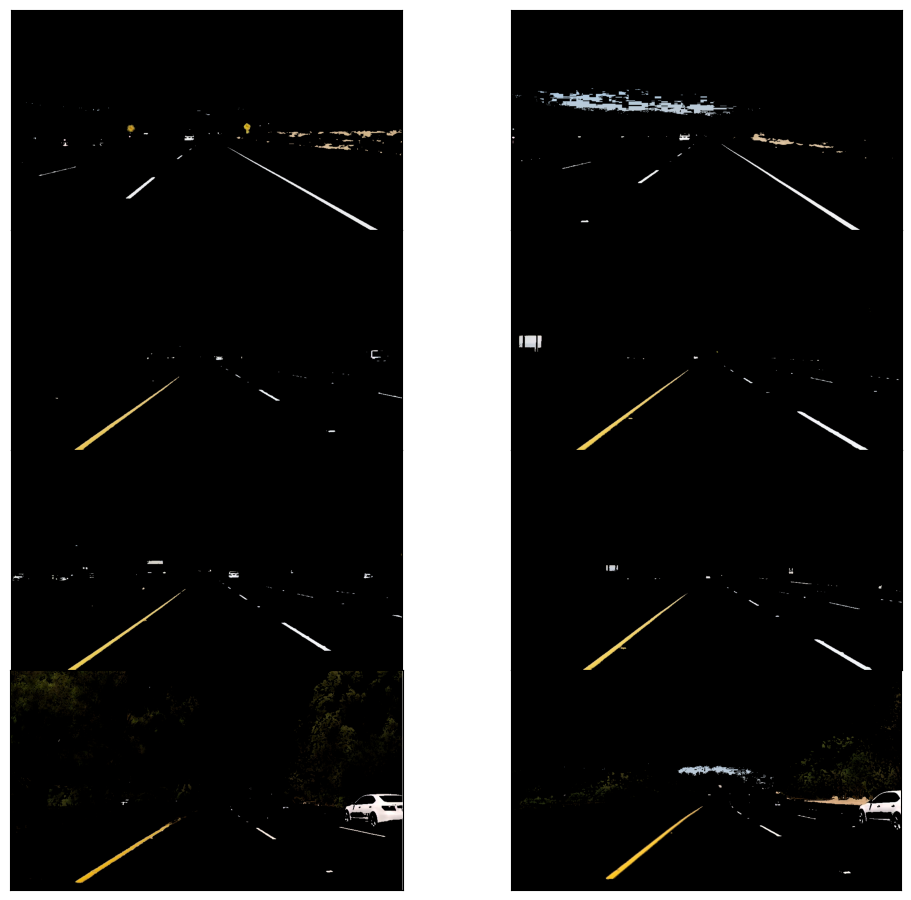

In [14]:
list_images(list(map(HSL_color_selection, test_images)))

### Using HSL produces the clearest lane lines of all color spaces. We will use them for the next steps.

In [15]:
color_selected_images = list(map(HSL_color_selection, test_images))

# list_images(list(test_images))

## 3. Canny Edge Detection

- It aims to detect the edges of objects within an image by identifying areas of significant intensity change. 
- The algorithm works by first smoothing the image to reduce noise, then finding the gradient magnitude and direction to highlight potential edges. 
- It then applies non-maximum suppression to thin the detected edges, and finally uses hysteresis thresholding to determine the final edge pixels. 
- Canny Edge Detection is widely used for tasks such as object detection, image segmentation, and feature extraction in various applications.

### a) Gray scaling the images

The Canny edge detection algorithm measures the intensity gradients of each pixel. So, we need to convert the images into gray scale in order to detect edges.

In [16]:
def gray_scale(image):
    """
    Convert images to gray scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

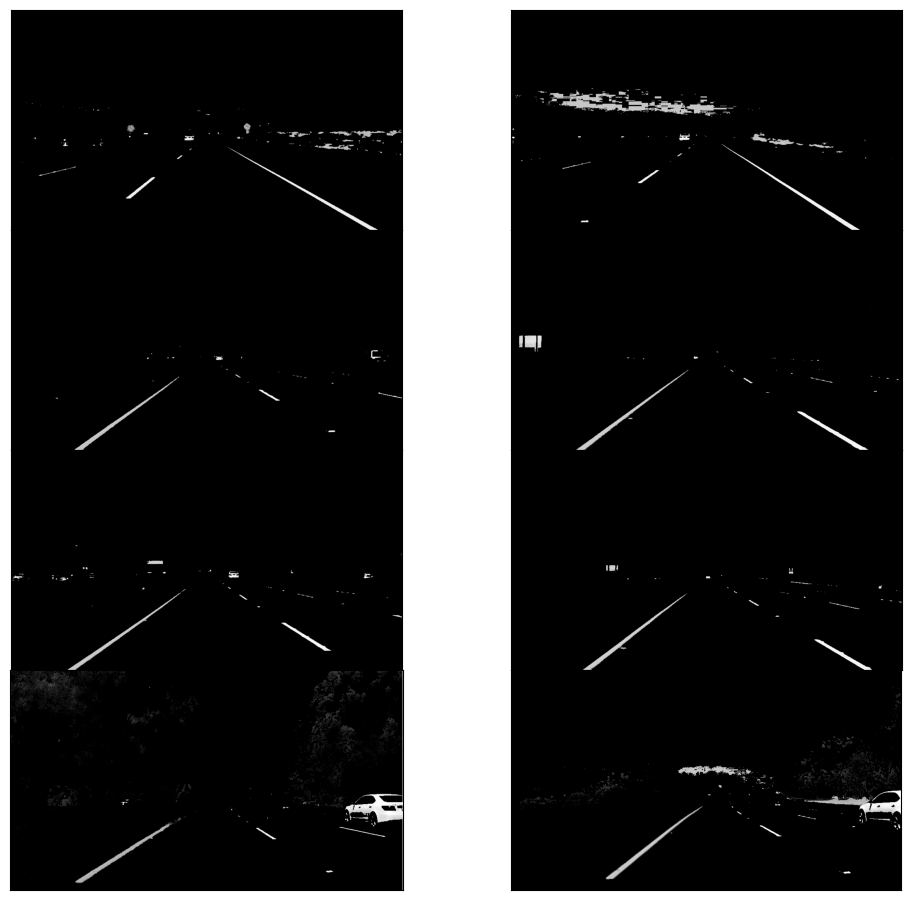

In [17]:
gray_images = list(map(gray_scale, color_selected_images))
list_images(gray_images)

### b) Applying Gaussian smoothing

- In lane detection, applying Gaussian smoothing involves blurring the image to reduce noise and enhance lane line detection accuracy. 
- This process employs a Gaussian filter to convolve the image, reducing high-frequency noise while preserving edges. 
- By smoothing the image, it becomes easier to identify lane lines accurately, as it minimizes the impact of small irregularities.

In [18]:
def gaussian_smoothing(image, kernel_size = 13):
    """
    Apply Gaussian filter to the input image.
        Parameters:
            image: An np.array compatible with plt.imshow.
            kernel_size (Default = 13): The size of the Gaussian kernel will affect the performance of the detector.
            It must be an odd number (3, 5, 7, ...).
    """
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

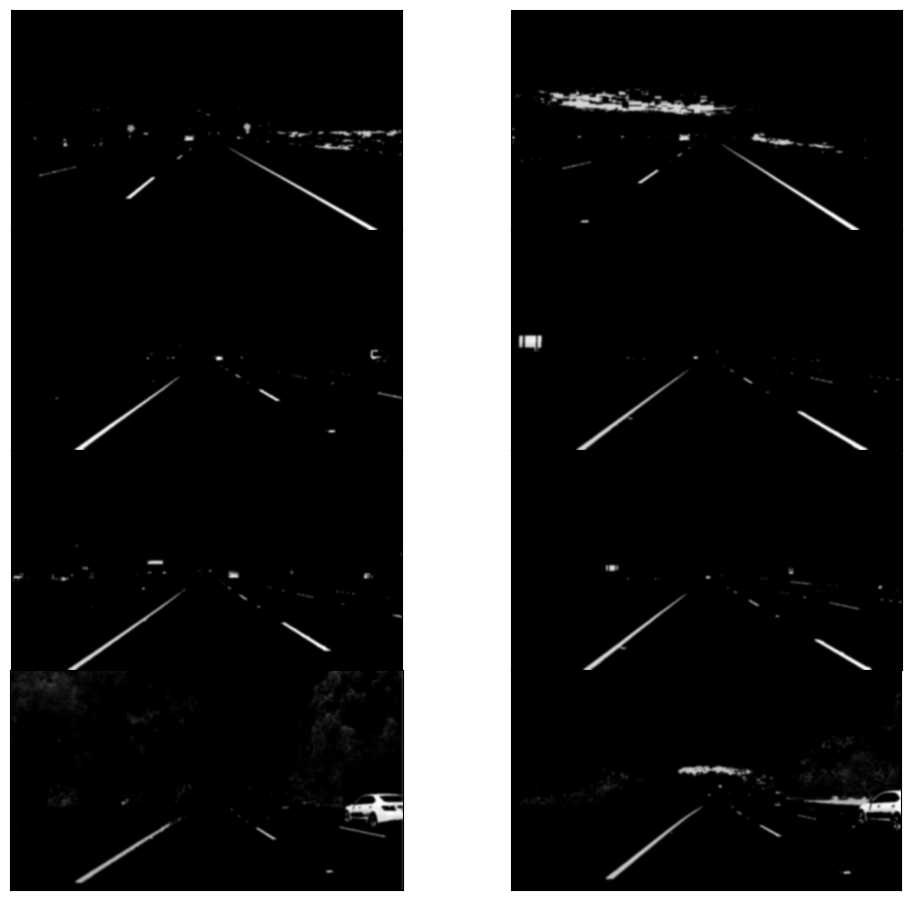

In [19]:
blur_images = list(map(gaussian_smoothing, gray_images))
list_images(blur_images)

### c) Applying Canny Edge Detection


The Process of Canny edge detection algorithm can be broken down to 5 different steps:
1. Find the intensity gradients of the image
2. Apply non-maximum suppression to get rid of spurious response to edge detection.
3. Apply *double threshold* to determine potential edges.
4. Track edge by hysteresis: Finalize the detection of edges by suppressing all the other edges that are weak and not connected to strong edges.

If an edge pixel’s gradient value is higher than the high threshold value, it is marked as a strong edge pixel. If an edge pixel’s gradient value is smaller than the high threshold value and larger than the low threshold value, it is marked as a weak edge pixel. If an edge pixel's value is smaller than the low threshold value, it will be suppressed.
The two threshold values are empirically determined and their definition will depend on the content of a given input image.

In [20]:
def canny_detector(image, low_threshold = 50, high_threshold = 150):
    """
    Apply Canny Edge Detection algorithm to the input image.
        Parameters: 
            image: An np.array compatible with plt.imshow.
            low_threshold (Default = 50).
            high_threshold (Default = 150).
    """
    return cv2.Canny(image, low_threshold, high_threshold)

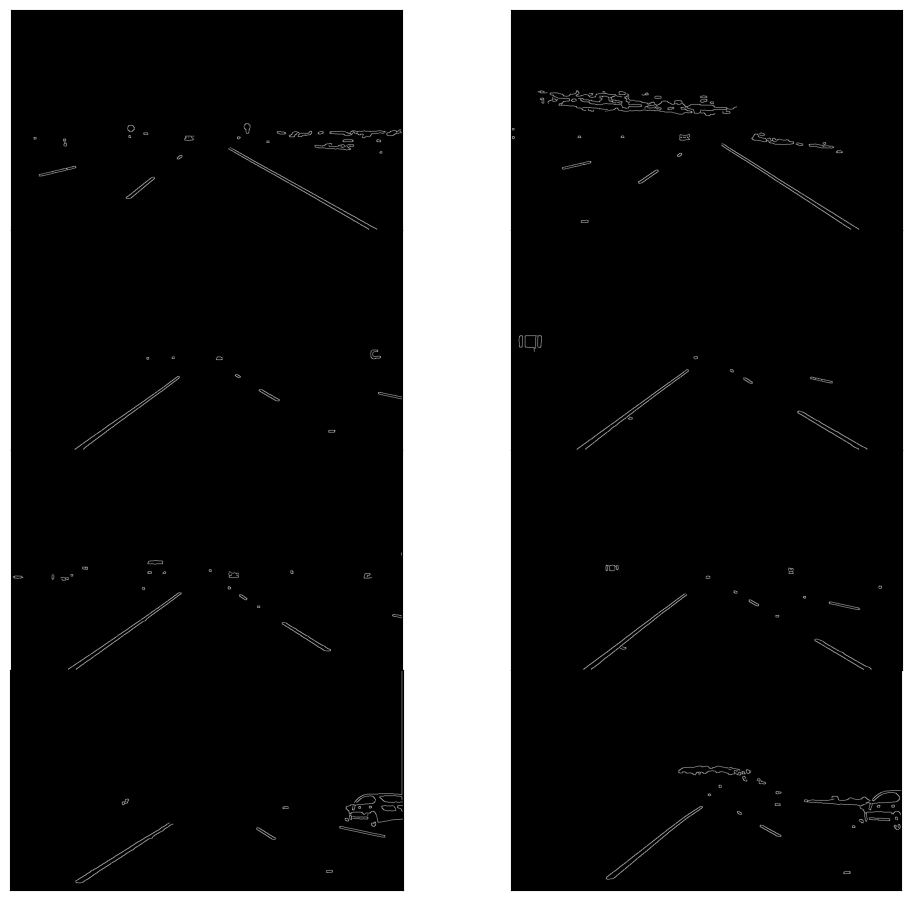

In [21]:
edge_detected_images = list(map(canny_detector, blur_images))
list_images(edge_detected_images) 

## 4. Region of interest


- The "region of interest" refers to the area within the camera frame where lane lines are expected to appear. This region is typically defined as a trapezoidal shape covering the road area ahead of the vehicle. By focusing analysis within this region, computational resources are optimized, and false positives are reduced. It enhances efficiency by ignoring irrelevant image areas. 

- We're interested in the area facing the camera, where the lane lines are found. So, we'll apply region masking to cut out everything else. 

In [22]:
def region_selection(image):
    """
    Determine and cut the region of interest in the input image.
    
    Parameters:
        image: An np.array compatible with plt.imshow.
    """
    # Create a blank mask with the same dimensions as the input image
    mask = np.zeros_like(image)
    
    # Define the color to fill the mask based on the number of channels in the image
    if len(image.shape) > 2:  # If the image has multiple channels
        channel_count = image.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:  # If the image has only one channel
        ignore_mask_color = 255
    
    # Define vertices of the polygon as a fraction of image dimensions
    rows, cols = image.shape[:2]
    bottom_left  = [cols * 0.1, rows * 0.95]
    top_left     = [cols * 0.4, rows * 0.6]
    bottom_right = [cols * 0.9, rows * 0.95]
    top_right    = [cols * 0.6, rows * 0.6]
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    
    # Fill the polygon defined by the vertices with ignore_mask_color
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # Apply the mask to the image using bitwise AND operation
    masked_image = cv2.bitwise_and(image, mask)
    
    return masked_image


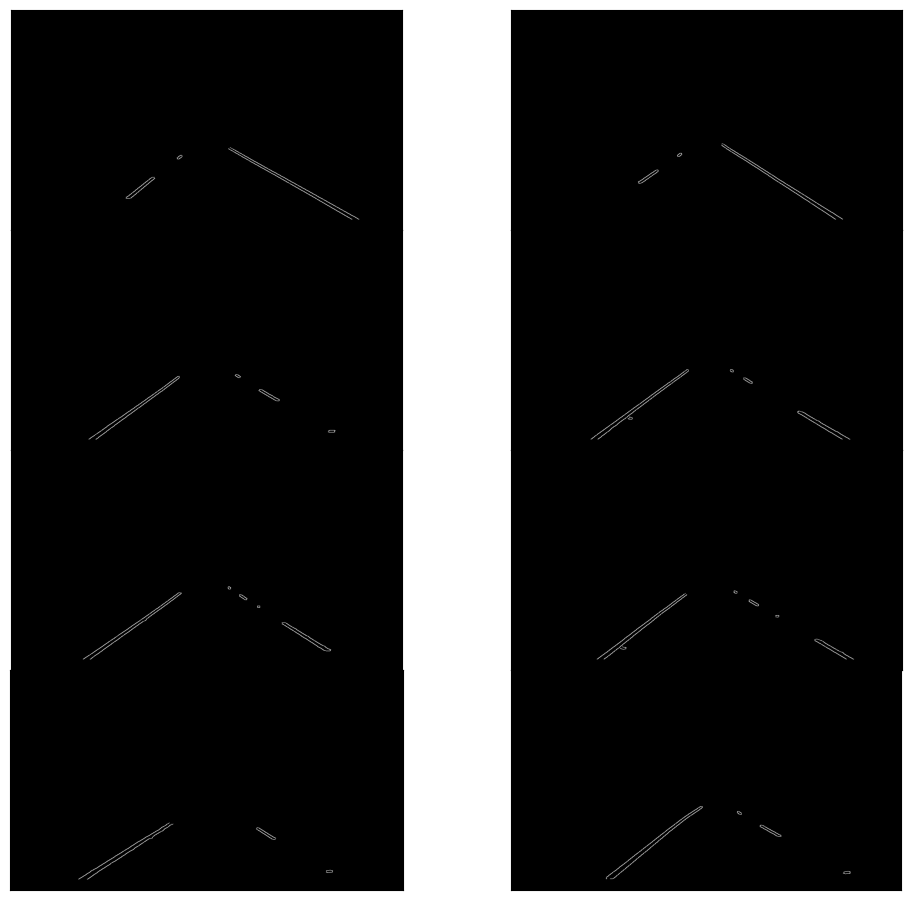

In [23]:
masked_image = list(map(region_selection, edge_detected_images))
list_images(masked_image)

## 5. Hough Transform

- The Hough transform is a technique which can be used to isolate features of a particular shape within an image. I'll use it to detected the lane lines in `selected_region_images`. 
- The Hough Transform helps in recognizing straight lines representing lane markings. By converting pixel coordinates into parameter space (slope and intercept for lines), it simplifies the detection process, overcoming challenges like gaps or noise. The algorithm detects lines even in the presence of breaks or interruptions. Lane lines are then identified based on peaks in the parameter space. 

In [24]:
def hough_transform(image):
    """
    Determine and cut the region of interest in the input image.
        Parameters:
            image: The output of a Canny transform.
    """
    rho = 1              #Distance resolution of the accumulator in pixels.
    theta = np.pi/180    #Angle resolution of the accumulator in radians.
    threshold = 20       #Only lines that are greater than threshold will be returned.
    minLineLength = 20   #Line segments shorter than that are rejected.
    maxLineGap = 300     #Maximum allowed gap between points on the same line to link them
    
    return cv2.HoughLinesP(image, rho = rho, theta = theta, threshold = threshold,
                           minLineLength = minLineLength, maxLineGap = maxLineGap)

### `hough_lines` contains the list of lines detected in the selected region. Now, we will draw these detected lines onto the original `test_images`.

In [25]:
hough_lines = list(map(hough_transform, masked_image))

In [26]:
# hough_lines for all images in the list -> (x1, y1), (x2, y2) for all lines
hough_lines

[array([[[544, 342, 852, 513]],
 
        [[532, 340, 824, 508]],
 
        [[603, 380, 835, 513]],
 
        [[294, 461, 415, 356]],
 
        [[282, 460, 340, 413]],
 
        [[285, 458, 412, 358]],
 
        [[536, 337, 580, 361]],
 
        [[290, 462, 419, 358]],
 
        [[537, 337, 842, 507]]], dtype=int32),
 array([[[516, 331, 774, 499]],
 
        [[517, 328, 808, 510]],
 
        [[645, 409, 811, 513]],
 
        [[517, 333, 794, 513]],
 
        [[312, 422, 417, 351]],
 
        [[319, 424, 418, 352]],
 
        [[519, 328, 616, 389]],
 
        [[322, 423, 418, 354]],
 
        [[312, 421, 415, 351]],
 
        [[516, 328, 812, 513]],
 
        [[515, 331, 795, 513]]], dtype=int32),
 array([[[193, 512, 412, 359]],
 
        [[207, 513, 403, 370]],
 
        [[190, 513, 411, 358]],
 
        [[549, 357, 647, 418]],
 
        [[552, 354, 789, 496]],
 
        [[550, 355, 792, 495]],
 
        [[377, 388, 410, 364]],
 
        [[209, 513, 344, 412]]], dtype=int32),
 array([[

In [27]:
def draw_lines(image, lines, color=[255, 0, 0], thickness=2):
    """
    Function to draw lines on an image.

    Parameters:
    - image: The image on which lines are to be drawn.
    - lines: A list of lines, where each line is represented by a list of four integers [x1, y1, x2, y2].
    - color: (Optional) Color of the lines in BGR format. Default is [255, 0, 0] (blue).
    - thickness: (Optional) Thickness of the lines. Default is 2 pixels.

    Returns:
    - The image with lines drawn on it.
    """
    image = np.copy(image)
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image

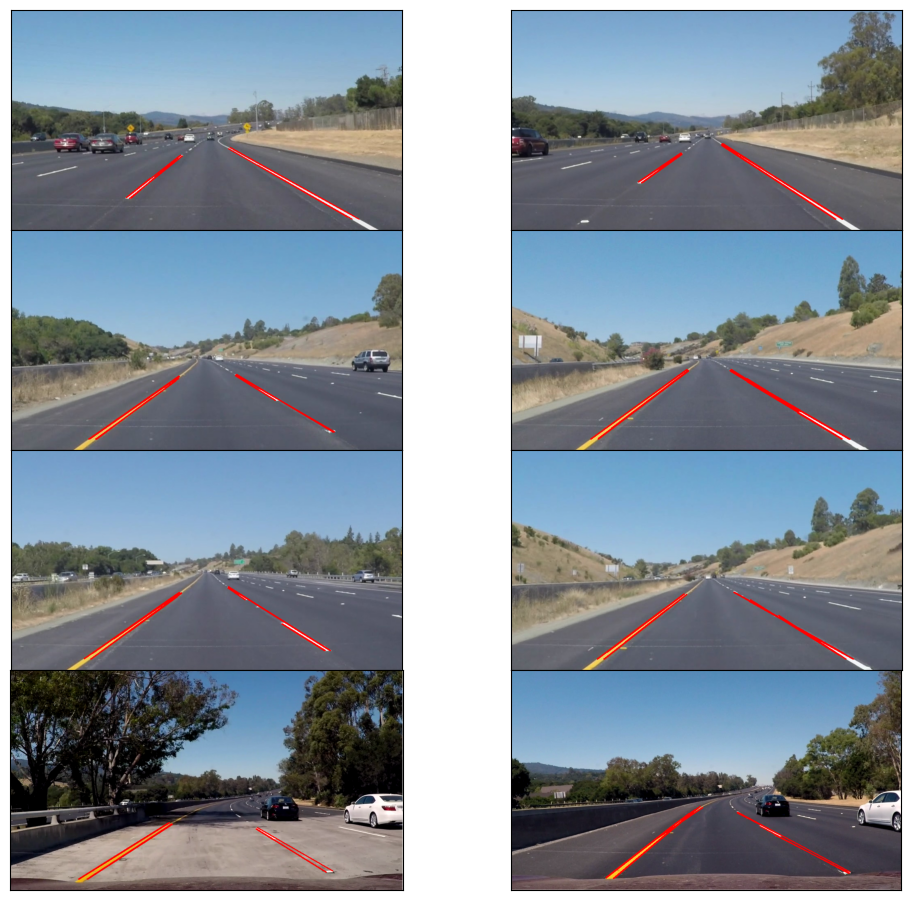

In [28]:
line_images = []
for image, lines in zip(test_images, hough_lines):
    # Draw lines on each image and append the result to line_images list
    line_images.append(draw_lines(image, lines))
    
# Display the list of images with lines drawn on them
list_images(line_images)


## 6. Averaging and extrapolating the lane lines

- We have multiple lines detected for each lane line. 
- We need to average all these lines and draw a single line for each lane line.
- We also need to extrapolate the lane lines to cover the full lane line length.

In [29]:
def average_slope_intercept(lines):
    """
    Find the slope and intercept of the left and right lanes of each image.
    
    Parameters:
    - lines: The output lines from Hough Transform.
    """
    left_lines = []  # List to store (slope, intercept) tuples for left lanes
    left_weights = []  # List to store the lengths of left lanes
    right_lines = []  # List to store (slope, intercept) tuples for right lanes
    right_weights = []  # List to store the lengths of right lanes
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            # For possible division by zero
            if x1 == x2:
                continue
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - (slope * x1)
            length = np.sqrt(((y2 - y1) ** 2) + ((x2 - x1) ** 2))
            if slope < 0:
                # Left lane
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                # Right lane
                right_lines.append((slope, intercept))
                right_weights.append((length))
                
    # Calculate weighted average of slopes and intercepts for left and right lanes
    # Weights are based on the length of each line, acknowledging that longer lines are more likely to accurately 
    # represent the lane's trajectory.
    left_lane = np.dot(left_weights, left_lines) / np.sum(left_weights) if len(left_weights) > 0 else None
    right_lane = np.dot(right_weights, right_lines) / np.sum(right_weights) if len(right_weights) > 0 else None
    
    return left_lane, right_lane

In [30]:
def pixel_points(y1, y2, line):
    """
    Convert slope and intercept to pixel points for drawing lanes on an image.

    Parameters:
    - y1: y-coordinate of the starting point of the lane.
    - y2: y-coordinate of the ending point of the lane.
    - line: Tuple containing slope and intercept of the lane.

    Returns:
    - Tuple containing pixel points ((x1, y1), (x2, y2)) representing the lane.
    """
    if line is None:
        return None
    slope, intercept = line
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    y1 = int(y1)
    y2 = int(y2)
    return ((x1, y1), (x2, y2))

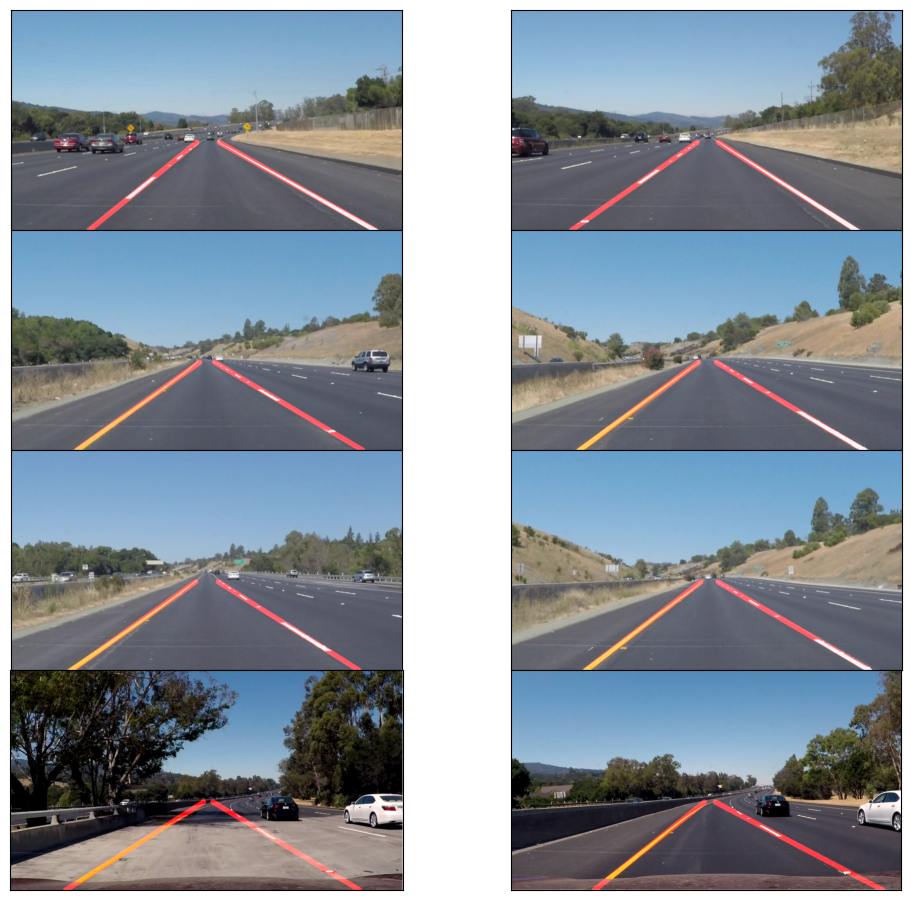

In [31]:
def lane_lines(image, lines):
    """
    Calculate pixel points for left and right lane lines.

    Parameters:
    - image: The input image.
    - lines: Detected lines from Hough Transform.

    Returns:
    - Tuple containing pixel points for left and right lane lines.
    """
    left_lane, right_lane = average_slope_intercept(lines)
    
    # Define y-coordinates for starting and ending points of the lanes
    y1 = image.shape[0]
    y2 = y1 * 0.6
    
    # Calculate pixel points for left and right lane lines
    left_line = pixel_points(y1, y2, left_lane)
    right_line = pixel_points(y1, y2, right_lane)
    return left_line, right_line

    
def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=12):
    """
    Draw lane lines onto the input image.

    Parameters:
    - image: The input test image.
    - lines: The output lines from Hough Transform.
    - color (Default = red): Line color.
    - thickness (Default = 12): Line thickness. 

    Returns:
    - Image with lane lines drawn on it.
    """
    # Create an empty image to draw lane lines on
    line_image = np.zeros_like(image)
    
    # Draw each lane line on the line image
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line, color, thickness)
            
    # Combine the original image with the line image
    return cv2.addWeighted(image, 1.0, line_image, 1.0, 0.0)
    
lane_images = []
for image, lines in zip(test_images, hough_lines):
    lane_images.append(draw_lane_lines(image, lane_lines(image, lines)))
    
list_images(lane_images)

## 7. Apply on video streams

Now, we'll use the above functions to detect lane lines from a video stream.

In [32]:
#Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML, Image

- Read a video file
- Process each frame 
- Save the processed video to a new file

In [33]:
def frame_processor(image):
    """
    Process the input frame to detect lane lines.

    Parameters:
    - image: Single video frame.

    Returns:
    - Processed frame with lane lines drawn on it.
    """
    color_select = HSL_color_selection(image)
    
    # Convert to grayscale
    gray = gray_scale(color_select)
    
    # Apply Gaussian smoothing
    smooth = gaussian_smoothing(gray)
    
    # Detect edges using Canny edge detector
    edges = canny_detector(smooth)
    
    # Select region of interest
    region = region_selection(edges)
    
    # Perform Hough transform to detect lines
    hough = hough_transform(region)
    
    # Draw lane lines on the frame
    result = draw_lane_lines(image, lane_lines(image, hough))
    
    return result

In [34]:
def process_video(test_video, output_video):
    """
    Read input video stream and produce a video file with detected lane lines.

    Parameters:
    - test_video: Input video.
    - output_video: A video file with detected lane lines.
    """
    # Read input video
    input_video = VideoFileClip(os.path.join('test_videos', test_video), audio=False)
    
    # Process each frame of the video using frame_processor function
    processed = input_video.fl_image(frame_processor)
    
    # Write the processed video to an output file
    processed.write_videofile(os.path.join('output_videos', output_video), audio=False)

In [35]:
# Measure the time taken to process the video
%time process_video('solidWhiteRight.mp4', 'solidWhiteRight_output.mp4')

Moviepy - Building video output_videos\solidWhiteRight_output.mp4.
Moviepy - Writing video output_videos\solidWhiteRight_output.mp4



Moviepy - Done !
Moviepy - video ready output_videos\solidWhiteRight_output.mp4
CPU times: total: 2.55 s
Wall time: 4.09 s


In [36]:
# Display the output video in the notebook
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("output_videos\solidWhiteRight_output.mp4"))

In [37]:
%time process_video('solidYellowLeft.mp4', 'solidYellowLeft_output.mp4')
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("output_videos\solidYellowLeft_output.mp4"))

Moviepy - Building video output_videos\solidYellowLeft_output.mp4.
Moviepy - Writing video output_videos\solidYellowLeft_output.mp4



Moviepy - Done !
Moviepy - video ready output_videos\solidYellowLeft_output.mp4
CPU times: total: 17.1 s
Wall time: 13.2 s


In [38]:
%time process_video('challenge.mp4', 'challenge_output.mp4')
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("output_videos\challenge_output.mp4"))

Moviepy - Building video output_videos\challenge_output.mp4.
Moviepy - Writing video output_videos\challenge_output.mp4



Moviepy - Done !
Moviepy - video ready output_videos\challenge_output.mp4
CPU times: total: 16.3 s
Wall time: 11.7 s
